# Final Project: Exploratory Analysis
## Predicting Trip Duration & Distance of Taxi Rides in Porto, Portugal

## Getting and Cleaning the Data: Test Set

The data sets were provided by Kaggle and can be downloaded, along with a description of all variables, from the [competition web page](kaggle.com/c/pkdd-15-predict-taxi-service-trajectory-i).

Since the goal of the competition was to predict the duration and distance of trips in the test data set with partial trajectories, I chose to filter the training data set based upon the month of a randomly selected test trip. I chose trip #40 (T40) which occured in the afternoon of Thursday August 14, 2015.

I then created the following features in order to quantify some characteristics of the partial trajectory:

Variable | Description
--- | ---
OE_ang | angle between the end point and the origin (0,0)
SE_ang,_bear | angle or bearing between the starting point and the end point
CE_ang,_bear | angle or bearing between the city center and the end point
OS_ang | angle between the origin and the starting point
CS_bear | bearing between the city center and the starting point
totalDist | summation of the displacement between GPS coordinates, Haversine formula
tripTime | time elapsed between the starting point and the end point of the partial trajectory, `(len(GPS_coordinates) - 1) * 15sec` since each GPS point was recorded every 15 seconds.
vel_endpoint | the velocity at the end of the parital trajectory
velAve | average velocity across entire partial trajectory

The angle, bearing, and distance computations were completed using the functions `computeAng`, `computeBearing`, and `computeDistance`.

The code used to engineer features for the test set can be found in the file entitled `TestTrip_FeatureEng.ipynb`. The final product of this file is a new test dataset CSV file entitled `test_featureEng.csv`.

Features such as `tripDistance` and `tripTime` were also computed for the training set following filtering due to computational demands.

## Getting and Clearning the Data: Training Set

The UNIX timestamp of the start of each trip in the training set was converted to datetime, and the training set was filtered so that only observations from the month of August were included in future analysis given the limited computing resources available.

The duration of the trip was approximated by multiplying one minus the number of GPS coordinates by 15 seconds since a new GPS coordinate was recorded every 15 seconds.

Training trips with less than 2 GPS points, trips shorter than 0.1 miles, and incomplete trajectories (`MISSING_VALUE == True`) were removed.

In [1]:
# Import modules

import pandas as  pd
import csv
import datetime
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from math import radians, cos, sin, atan2, sqrt, floor, pi
import ast
from tqdm import tqdm
import seaborn as sns
from sklearn import metrics, tree, ensemble, cross_validation, grid_search, neighbors,cluster
from scipy.stats import stats, levene, kstest, ks_2samp
from IPython.display import Image
import os

# Import taxi functions
from taxiTripFunctions import computeAng, computeBearing, computeDistance, directionality,dtw_distances,dtw_start_cost,path_cost

%matplotlib inline

In [2]:
%%time

# Read raw data, training
data_raw = pd.read_csv('train.csv')

Wall time: 46.2 s


In [3]:
%%time

data = data_raw

# Convert UNIX to datetime
dateVec = []
for i in range(0,data.TIMESTAMP.count()):
    temp = datetime.datetime.fromtimestamp(int(data.TIMESTAMP.ix[i])).strftime('%W %a %b %d %Y %H:%M:%S').split(' ')
    temp = temp[:-1] + temp[5].split(':')
    dateVec.append(temp)

Wall time: 3min


In [4]:
%%time

# Separate date components and add to a new data frame
dateVecColNames = ['wknum', 'wkday','month','day','year','hour','minute','sec'];
date_df = pd.DataFrame(dateVec, columns = dateVecColNames)
date_df.wknum = map(int,date_df.wknum)
date_df.day = map(int,date_df.day)
date_df.hour = map(int,date_df.hour)

Wall time: 7.21 s


In [5]:
# Concat dataframes
data2 = pd.concat([data,date_df], axis = 1)

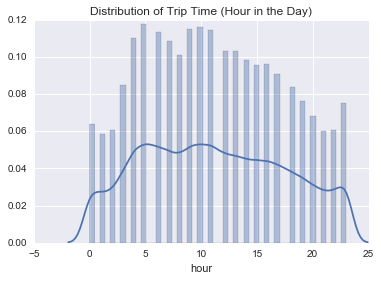

In [6]:
# Filter for August observations and reset index
data2 = data2.loc[data2.month == 'Aug',:].reset_index(drop = True)
sns.distplot(data2.hour)
plt.title('Distribution of Trip Time (Hour in the Day)')

In [7]:
%%time

# compute tripTime

tripTime = []
lenGPSArray = []
totalDist = []

for i in range(data2.TIMESTAMP.count()):
    temp1 = ast.literal_eval(data2.POLYLINE.ix[i,:])
    lenGPS = len(temp1)
    temp = (lenGPS - 1) * 15
    lenGPSArray.append(lenGPS)    
    tripTime.append(temp / 60) #in minutes!!!!
    if (len(temp1) > 1):
        totalDist.append(computeDistance(temp1)[1])
    else:
        totalDist.append(0)

Wall time: 3min 26s


In [8]:
tripTime_df = pd.DataFrame(tripTime, columns = ['tripTime'])
data2 = pd.concat([data2,tripTime_df],axis=1)

lenGPS_df = pd.DataFrame(lenGPSArray, columns = ['lenGPS'])
data2 = pd.concat([data2,lenGPS_df],axis=1)

totalDist_df = pd.DataFrame(totalDist, columns = ['totalDist'])
data2 = pd.concat([data2,totalDist_df],axis=1)

data3 = data2.copy()

# Save for rapid loading later
data3.to_csv('training_featureEng.csv')

In [9]:
# Read training data set with engineered features
# data_raw = pd.read_csv('train_featureEng.csv')
# data3 = data_raw

# Remove observations with 0 GPS points, missing data, short trips (time)
GPSlenThresh = 2
distThresh = 0.1
data3 = data3[(data3.MISSING_DATA == False) &\
                (data3.tripTime > 1) &\
                (data3.totalDist > distThresh) &\
                (data3.lenGPS >= GPSlenThresh)]
data3 = data3.reset_index(drop = True)

# Convert missing origin and call information from NAN to 0
data3.loc[np.isnan(data3.ORIGIN_STAND),'ORIGIN_STAND'] = 0
data3.loc[np.isnan(data3.ORIGIN_CALL),'ORIGIN_CALL'] = 0

## Exploratory Analysis: Part I

In [11]:
# Compare the means of each group to see if they are statistically different
#print data.tripTime.groupby(data.wkday).describe()
print 'Skewness Measure, Trip Time'
print 'Mon: ' + str(stats.skew(data3.tripTime[data3.wkday == 'Mon']))
print 'Tue: ' + str(stats.skew(data3.tripTime[data3.wkday == 'Tue']))
print 'Wed: ' + str(stats.skew(data3.tripTime[data3.wkday == 'Wed']))
print 'Thu: ' + str(stats.skew(data3.tripTime[data3.wkday == 'Thu']))
print 'Fri: ' + str(stats.skew(data3.tripTime[data3.wkday == 'Fri']))
print 'Sat: ' + str(stats.skew(data3.tripTime[data3.wkday == 'Sat']))
print 'Sun: ' + str(stats.skew(data3.tripTime[data3.wkday == 'Sun']))

print
print 'Skewness Measure, Trip Distance'
print 'Mon: ' + str(stats.skew(data3.totalDist[data3.wkday == 'Mon']))
print 'Tue: ' + str(stats.skew(data3.totalDist[data3.wkday == 'Tue']))
print 'Wed: ' + str(stats.skew(data3.totalDist[data3.wkday == 'Wed']))
print 'Thu: ' + str(stats.skew(data3.totalDist[data3.wkday == 'Thu']))
print 'Fri: ' + str(stats.skew(data3.totalDist[data3.wkday == 'Fri']))
print 'Sat: ' + str(stats.skew(data3.totalDist[data3.wkday == 'Sat']))
print 'Sun: ' + str(stats.skew(data3.totalDist[data3.wkday == 'Sun']))

print
# KS test to compare distributions.
# H0: samples are pulled from the same distribution/ the distributions are similar
# If p-value < 0.05, reject H0
print 'KS test, Trip Distance: Mon vs. Tue/Wed/Thu/Fri/Sat/Sun'
print ks_2samp(data3.totalDist[data3.wkday == 'Mon'], data3.totalDist[data3.wkday == 'Tue'])
print ks_2samp(data3.totalDist[data3.wkday == 'Mon'], data3.totalDist[data3.wkday == 'Wed'])
print ks_2samp(data3.totalDist[data3.wkday == 'Mon'], data3.totalDist[data3.wkday == 'Thu'])
print ks_2samp(data3.totalDist[data3.wkday == 'Mon'], data3.totalDist[data3.wkday == 'Fri'])
print ks_2samp(data3.totalDist[data3.wkday == 'Mon'], data3.totalDist[data3.wkday == 'Sat'])
print ks_2samp(data3.totalDist[data3.wkday == 'Mon'], data3.totalDist[data3.wkday == 'Sun'])

print
# KS test to compare distributions.
# H0: samples are pulled from the same distribution/ the distributions are similar
# If p-value < 0.05, reject H0
print 'KS test, Trip Time: Mon vs. Tue/Wed/Thu/Fri/Sat/Sun'
print ks_2samp(data3.tripTime[data3.wkday == 'Mon'], data3.tripTime[data3.wkday == 'Tue'])
print ks_2samp(data3.tripTime[data3.wkday == 'Mon'], data3.tripTime[data3.wkday == 'Wed'])
print ks_2samp(data3.tripTime[data3.wkday == 'Mon'], data3.tripTime[data3.wkday == 'Thu'])
print ks_2samp(data3.tripTime[data3.wkday == 'Mon'], data3.tripTime[data3.wkday == 'Fri'])
print ks_2samp(data3.tripTime[data3.wkday == 'Mon'], data3.tripTime[data3.wkday == 'Sat'])
print ks_2samp(data3.tripTime[data3.wkday == 'Mon'], data3.tripTime[data3.wkday == 'Sun'])

 Skewness Measure, Trip Time
Mon: 25.0342950363
Tue: 9.49750383158
Wed: 13.1904163429
Thu: 21.1327273278
Fri: 11.3987157011
Sat: 18.1046453359
Sun: 9.74882438835

Skewness Measure, Trip Distance
Mon: 21.4923312937
Tue: 62.4767645396
Wed: 11.9840995888
Thu: 19.9123367098
Fri: 24.8742619383
Sat: 22.9136723426
Sun: 16.5740286062

KS test, Trip Distance: Mon vs. Tue/Wed/Thu/Fri/Sat/Sun
Ks_2sampResult(statistic=0.00883085031877473, pvalue=0.57922980074326913)
Ks_2sampResult(statistic=0.010330960291175306, pvalue=0.37019910500964714)
Ks_2sampResult(statistic=0.011387427363210079, pvalue=0.21534572860869425)
Ks_2sampResult(statistic=0.012200490054164459, pvalue=0.1267271435324554)
Ks_2sampResult(statistic=0.02116606740698046, pvalue=0.00070196724066292596)
Ks_2sampResult(statistic=0.050496626874851402, pvalue=1.5384658816847906e-15)

KS test, Trip Time: Mon vs. Tue/Wed/Thu/Fri/Sat/Sun
Ks_2sampResult(statistic=0.0075517210186484274, pvalue=0.76704019643637866)
Ks_2sampResult(statistic=0.014692

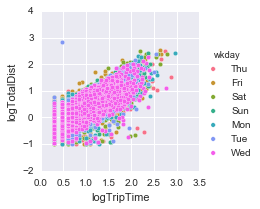

In [13]:
data3[['logTripTime','logTotalDist']] = np.log10(data3.loc[:,['tripTime','totalDist']])
g = sns.FacetGrid(data3, hue="wkday")
g.map(plt.scatter, "logTripTime", "logTotalDist", edgecolor="white")
g.add_legend();

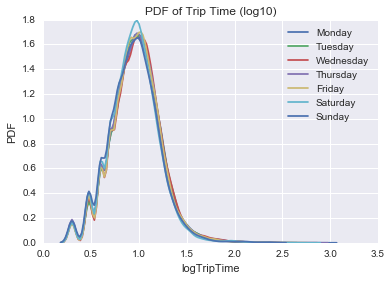

In [14]:
sns.distplot(data3.logTripTime.loc[data3.wkday == 'Mon'], hist = False, label = 'Monday')
sns.distplot(data3.logTripTime.loc[data3.wkday == 'Tue'], hist = False, label = 'Tuesday')
sns.distplot(data3.logTripTime.loc[data3.wkday == 'Wed'], hist = False, label = 'Wednesday')
sns.distplot(data3.logTripTime.loc[data3.wkday == 'Thu'], hist = False, label = 'Thursday')
sns.distplot(data3.logTripTime.loc[data3.wkday == 'Fri'], hist = False, label = 'Friday')
sns.distplot(data3.logTripTime.loc[data3.wkday == 'Sat'], hist = False, label = 'Saturday')
sns.distplot(data3.logTripTime.loc[data3.wkday == 'Sun'], hist = False, label = 'Sunday')
plt.ylabel('PDF')
plt.title('PDF of Trip Time (log10)')

#g = sns.FacetGrid(data, row="wkday", row_order = data.wkday.value_counts().index,size=1.7, aspect=4,)
#g.map(sns.distplot, "logTripTime", hist=False, rug=True);

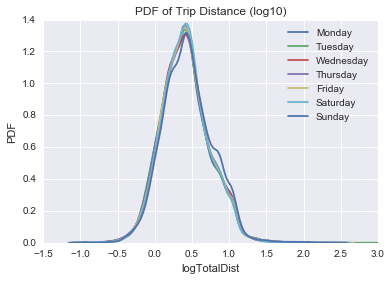

In [15]:
sns.distplot(data3.logTotalDist.loc[data3.wkday == 'Mon'], hist = False, label = 'Monday')
sns.distplot(data3.logTotalDist.loc[data3.wkday == 'Tue'], hist = False, label = 'Tuesday')
sns.distplot(data3.logTotalDist.loc[data3.wkday == 'Wed'], hist = False, label = 'Wednesday')
sns.distplot(data3.logTotalDist.loc[data3.wkday == 'Thu'], hist = False, label = 'Thursday')
sns.distplot(data3.logTotalDist.loc[data3.wkday == 'Fri'], hist = False, label = 'Friday')
sns.distplot(data3.logTotalDist.loc[data3.wkday == 'Sat'], hist = False, label = 'Saturday')
sns.distplot(data3.logTotalDist.loc[data3.wkday == 'Sun'], hist = False, label = 'Sunday')
plt.ylabel('PDF')
plt.title('PDF of Trip Distance (log10)')

In [16]:
data_raw3 = data3
data4 = data3[data3.wkday == 'Thu'].reset_index(drop = True)

## Exploratory Analysis: Part II

Next, additional features were engineered for the training and test sets. Observations with trajectories that were greater than or equal to the test trajectory in length were used for the remainder of this analysis.

In [17]:
# load test set
test_raw = pd.read_csv('test_featureEng.csv')
test = test_raw

testTrip = test.loc[39,:] # on a Thursday in August at 1pm
temp = ast.literal_eval(testTrip['POLYLINE'])
cutOffTime = (len(temp)-1) * 15 # seconds
cutOffTimeIdx = (cutOffTime / 15) + 1
testTripStart = temp[0]
testTripEnd = temp[-1]

In [18]:
%%time

# create more features for the training data

data4 = data4[data4.lenGPS > cutOffTimeIdx].reset_index(drop = True)

cityCenter = np.array([-8.6291,41.1579])
origin_cc_ang = computeAng(cityCenter,[])

startGPS,endGPS,lenGPS, startGPSLong, startGPSLat, endGPSLong, endGPSLat = [],[],[],[],[],[],[]
midGPSLong,midGPSLat, coGPSLong, coGPSLat = [],[],[],[]
origin_end_ang,start_end_ang,cc_end_ang,origin_start_ang,cc_start_ang = [],[],[],[],[]
start_end_bearing, cc_end_bearing, cc_start_bearing = [],[],[]
origin_co_ang,start_co_ang,cc_co_ang,co_end_ang,start_co_bearing,cc_co_bearing,co_end_bearing = [],[],[],[],[],[],[]
origin_mid_ang,start_mid_ang,cc_mid_ang,mid_end_ang,start_mid_bearing,cc_mid_bearing,mid_end_bearing = [],[],[],[],[],[],[]
distCo,distMid,velCo,velMid,velAve,tripTimeCo,tripTimeMid,distAbs, distDiff = [],[],[],[],[],[],[],[],[]
SMid_direction,SE_direction,SCo_direction,CMid_direction,CE_direction,CCo_direction = [],[],[],[],[],[]

for i in range(len(data4)):
    temp = ast.literal_eval(data4.POLYLINE.ix[i])
    lenGPS.append(len(temp))
    
    startPt = temp[0]
    endPt = temp[-1]
    ind = int(floor(len(temp) / 2.0))
    midPt = temp[ind]
    coPt = temp[cutOffTimeIdx]
    
    startGPS.append(startPt)
    endGPS.append(endPt)
    startGPSLat.append(startPt[1])
    startGPSLong.append(startPt[0])
    endGPSLat.append(endPt[1])
    endGPSLong.append(endPt[0])
    midGPSLat.append(midPt[1])
    midGPSLong.append(midPt[0])
    coGPSLong.append(coPt[0])
    coGPSLat.append(coPt[1])
     
    origin_end_ang.append(computeAng(endPt,[]))
    start_end_ang.append(computeAng(startPt,endPt))
    cc_end_ang.append(computeAng(cityCenter,endPt))
    origin_start_ang.append(computeAng(startPt,[]))
    cc_start_ang.append(computeAng(cityCenter,startPt))
    origin_co_ang.append(computeAng(coPt,[]))
    start_co_ang.append(computeAng(startPt,coPt))
    cc_co_ang.append(computeAng(cityCenter,coPt))
    co_end_ang.append(computeAng(coPt,endPt))
    origin_mid_ang.append(computeAng(midPt,[]))
    start_mid_ang.append(computeAng(startPt,midPt))
    cc_mid_ang.append(computeAng(cityCenter,midPt))
    mid_end_ang.append(computeAng(midPt,endPt))
        
    start_end_bearing.append(computeBearing(startPt,endPt))
    cc_end_bearing.append(computeBearing(cityCenter,endPt))
    cc_start_bearing.append(computeBearing(cityCenter,startPt))
    start_co_bearing.append(computeBearing(startPt,coPt))
    cc_co_bearing.append(computeBearing(cityCenter,coPt))
    co_end_bearing.append(computeBearing(coPt,endPt))
    start_mid_bearing.append(computeBearing(startPt,midPt))
    cc_mid_bearing.append(computeBearing(cityCenter,midPt))
    mid_end_bearing.append(computeBearing(midPt,endPt))
    
    SMid_direction.append(directionality(start_mid_bearing[-1]))
    SE_direction.append(directionality(start_end_bearing[-1]))
    SCo_direction.append(directionality(start_co_bearing[-1]))
    CMid_direction.append(directionality(cc_mid_bearing[-1]))
    CE_direction.append(directionality(cc_end_bearing[-1]))
    CCo_direction.append(directionality(cc_co_bearing[-1]))
                      
        
    if (len(temp) > 1):
        # compute distance to cut off
        distVec0,sumDist = computeDistance(temp[:cutOffTimeIdx])
        distCo.append(sumDist)
        distVec0,sumDist = computeDistance(temp[:ind])
        distMid.append(sumDist)
        distVec0,sumDist = computeDistance(list([temp[0],temp[-1]]))
        distAbs.append(sumDist)
        
        distVec0,sumDist = computeDistance(list([midPt,testTripEnd]))
        distDiff.append(sumDist)

        # compute velocity at cut off, last 30 sec and across entire trip
        distVec0,sumDist = computeDistance(temp[:cutOffTimeIdx+2])
        velCo.append(60 * 60 * np.asarray(distVec0[-4:]).sum() / 60.0)
        distVec0,sumDist = computeDistance(temp[:ind+2])
        velMid.append(60 * 60 * np.asarray(distVec0[-4:]).sum() / 60.0)
        
        tripTimeCo.append((cutOffTimeIdx-1)*15 / 60.0)
        tripTimeMid.append((ind-1)*15 / 60.0)
    else:
        distCo.append(0)
        distMid.append(0)
        velCo.append(0)
        velMid.append(0)
        tripTimeCo.append(0)
        tripTimeMid.append(0)
        distAbs.append(0)
        
velAve = 60.0 * data4.totalDist / data4.tripTime                      
    
GPS_add = {'startGPS': startGPS,\
           'endGPS': endGPS,\
           'startGPSLong': startGPSLong,\
           'startGPSLat': startGPSLat,\
           'endGPSLong': endGPSLong,\
           'endGPSLat': endGPSLat,\
           'midGPSLong': midGPSLong,\
           'midGPSLat': midGPSLat,\
           'coGPSLat': coGPSLat,\
           'coGPSLong': coGPSLong,\
           'OE_ang': origin_end_ang,\
           'SE_ang': start_end_ang,\
           'CE_ang': cc_end_ang,\
           'OS_ang': origin_start_ang,\
           'CS_ang': cc_start_ang,\
           'SE_bear': start_end_bearing,\
           'CE_bear': cc_end_bearing,\
           'CS_bear': cc_start_bearing,\
           'OCo_ang': origin_co_ang,\
           'SCo_ang': start_co_ang,\
           'CCo_ang': cc_co_ang,\
           'CoE_ang': co_end_ang,\
           'SCo_bear': start_co_bearing,\
           'CCo_bear': cc_co_bearing,\
           'CoE_bear': co_end_bearing,\
           'OMid_ang': origin_mid_ang,\
           'SMid_ang': start_mid_ang,\
           'CMid_ang': cc_mid_ang,\
           'MidE_ang': mid_end_ang,\
           'SMid_bear': start_mid_bearing,\
           'CMid_bear': cc_mid_bearing,\
           'MidE_bear': mid_end_bearing,\
           'distCo': distCo,\
           'distMid': distMid,\
           'velCo': velCo,\
           'velMid': velMid,\
           'velAve': velAve,
           'timeMid': tripTimeMid,\
           'timeCo': tripTimeCo,\
           'distAbs': distAbs,\
           'distDiff': distDiff,\
           'SMid_direction':SMid_direction,\
           'SE_direction': SE_direction,\
           'SCo_direction': SCo_direction,\
           'CMid_direction': CMid_direction,\
           'CE_direction': CE_direction,\
           'CCo_direction': CCo_direction\
          }                     
                      
GPS_add_df = pd.DataFrame(data = GPS_add)

Wall time: 41.2 s


In [19]:
data4 = pd.concat([data4,GPS_add_df], axis = 1)
data4['logDistAbs'] = np.log10(data4.distAbs)

In [20]:
data5 = data4.copy()
dropCol = ['TRIP_ID','TIMESTAMP','MISSING_DATA','wknum','day','year','minute','sec','wkday','month']
data5 = data5.drop(dropCol, axis = 1)
data5.head(2)

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,DAY_TYPE,POLYLINE,hour,tripTime,lenGPS,totalDist,...,midGPSLong,startGPS,startGPSLat,startGPSLong,timeCo,timeMid,velAve,velCo,velMid,logDistAbs
0,A,4865.0,0.0,20000338,A,"[[-8.611038,41.147487],[-8.611047,41.147658],[...",0,8,33,1.572089,...,-8.602263,"[-8.611038, 41.147487]",41.147487,-8.611038,5.0,3.75,11.790671,28.899583,6.399790,0.121933
1,A,6728.0,0.0,20000542,A,"[[-8.613108,41.140494],[-8.613108,41.140503],[...",0,10,43,3.084684,...,-8.581239,"[-8.613108, 41.140494]",41.140494,-8.613108,5.0,5.00,18.508102,32.608752,32.608752,0.186246


## Exploratory Analysis: Part III

Next, I checked to see if trip time and distance traveled were dependent upon the time of the day in which the trip occured. The probability distribution functions across blocks of time denoted "day","night","morning rush" (rush hour traffic), etc. overlap for all major periods of a work day except evening rush hour. Plotting the average trip time and distance suggests longer trips (in time and distance) were taken during the early morning hours and the longest (time) trips occured between the hours of 5am & 6am,8pm-9pm, and 11pm-12am.

To finalize this data set, I removed time and distance outliers via the interquartile range (IQR) and used observations collected between 5am and 8pm.

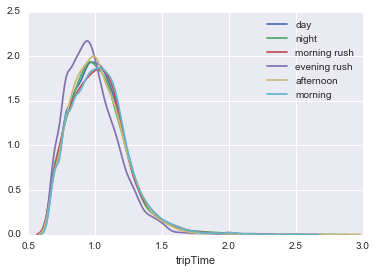

In [21]:
afternoon = range(12,19) #noon to 6pm
morning = range(6,13) #6am to noon
night = range(20,25) + range(0,6) #8pm to midnight, midnight to 5am
morningRush = range(6,11) #6am to 10am
eveningRush = range(16,21) #4pm to 8pm
day = range(4,20) #4am to 7pm

nightBool = [i in night for i in data5.hour]
dayBool = [i in day for i in data5.hour]
afterNoonBool = [i in afternoon for i in data5.hour]
morningBool = [i in morning for i in data5.hour]
morningRushBool = [i in morningRush for i in data5.hour]
eveningRushBool = [i in eveningRush for i in data5.hour]

sns.distplot(np.log10(data5.tripTime[dayBool]), hist = False, label = 'day')
sns.distplot(np.log10(data5.tripTime[nightBool]), hist = False, label = 'night')
sns.distplot(np.log10(data5.tripTime[morningRushBool]), hist = False, label = 'morning rush')
sns.distplot(np.log10(data5.tripTime[eveningRushBool]), hist = False, label = 'evening rush')
sns.distplot(np.log10(data5.tripTime[afterNoonBool]), hist = False, label = 'afternoon')
sns.distplot(np.log10(data5.tripTime[morningBool]), hist = False, label = 'morning')

C:\Anaconda2\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


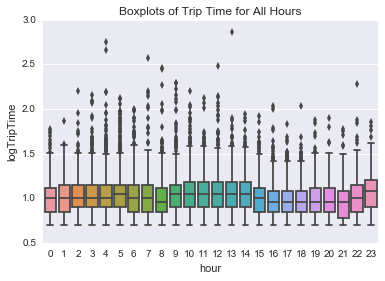

In [22]:
sns.boxplot(data5.logTripTime, groupby = data5.hour)
plt.title('Boxplots of Trip Time for All Hours')

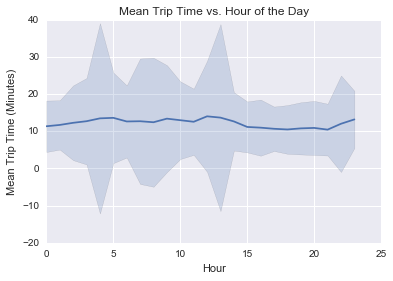

In [23]:
err = data5.tripTime.groupby(data5.hour).std()
y = data5.tripTime.groupby(data5.hour).mean()
x = range(data5.hour.min(),data5.hour.max()+1)

plt.plot(x,y)
plt.xlabel('Hour')
plt.ylabel('Mean Trip Time (Minutes)')
plt.title('Mean Trip Time vs. Hour of the Day')

#standard deviation
plt.fill_between(x, y-err, y+err,alpha=0.2)

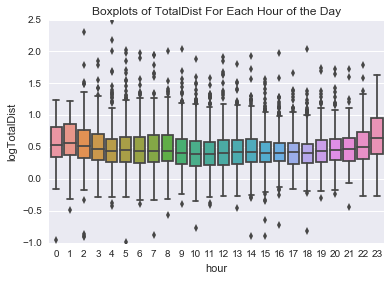

In [24]:
sns.boxplot(data5.logTotalDist, groupby = data5.hour)
plt.title('Boxplots of TotalDist For Each Hour of the Day')

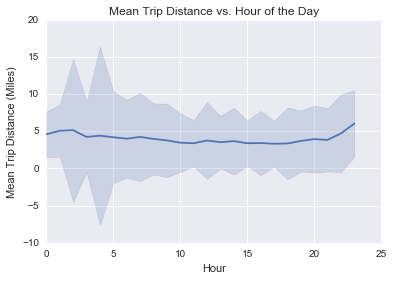

In [25]:
err = data5.totalDist.groupby(data5.hour).std()
y = data5.totalDist.groupby(data5.hour).mean()
x = range(data5.hour.min(),data5.hour.max()+1)

plt.plot(x,y)
plt.fill_between(x, y-err, y+err,alpha=0.2)
plt.xlabel('Hour')
plt.ylabel('Mean Trip Distance (Miles)')
plt.title('Mean Trip Distance vs. Hour of the Day')

In [26]:
%%time

# compute outlier range
lowerTime,upperTime,lowerDist,upperDist = [],[],[],[]
for i in range(24):
    #time
    q75,q25 = np.percentile(data5.tripTime[data5.hour == i], [75,25])
    IQR = q75 - q25
    lowerTime.append(q25 - (1.5*IQR))
    upperTime.append(q75 + (1.5*IQR))
    
    #distance
    q75,q25 = np.percentile(data5.totalDist[data5.hour == i], [75,25])
    IQR = q75 - q25
    lowerDist.append(q25 - (1.5*IQR))
    upperDist.append(q75 + (1.5*IQR))

Wall time: 123 ms


In [27]:
%%time

# find indicies of outliers
idx = []
for i in range(len(data5)):
    if (lowerTime[data5.hour[i]] <= data5.loc[i,'tripTime']) &  (data5.loc[i,'tripTime']<= upperTime[data5.hour[i]]):
        idx.append(False)
    else:
        idx.append(True)
idxTime = np.where(idx)[0]


idx = []
for i in range(len(data5)):
    if (lowerDist[data5.hour[i]] <= data5.loc[i,'totalDist']) &  (data5.loc[i,'totalDist']<= upperDist[data5.hour[i]]):
        idx.append(False)
    else:
        idx.append(True)
idxDist = np.where(idx)[0]

rmvIdx = np.unique(np.concatenate((idxDist,idxTime)))
keepIdx = list(set(range(len(data5))) - set(rmvIdx))

Wall time: 43.8 s


In [28]:
# remove outliers, keep between 5am and 8pm
data6 = data5.copy()
data6 = data6.loc[keepIdx,:].reset_index(drop = True)
data6 = data6.loc[(data6.hour <= 20) & (data6.hour >= 5),:].reset_index(drop = True)

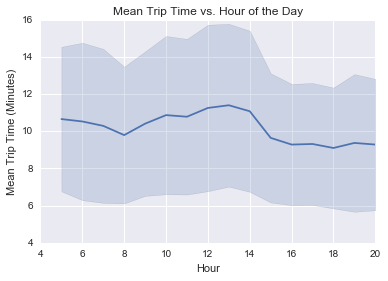

In [29]:
err = data6.tripTime.groupby(data6.hour).std()
y = data6.tripTime.groupby(data6.hour).mean()
x = range(data6.hour.min(),data6.hour.max()+1)

plt.plot(x,y)
plt.fill_between(x, y-err, y+err,alpha=0.2)
plt.xlabel('Hour')
plt.ylabel('Mean Trip Time (Minutes)')
plt.title('Mean Trip Time vs. Hour of the Day')

## Cluster Analysis: Dynamic Time Warping

### Part I: Find closest trajectories

I chose to use dynamic time warping in order to identify trajectories in the training set that overlap the partial trajectory of trip # 40 in the test set. First, I filtered the training data set so that my working data set only included trajectories that had at least one GPS coordinate within 0.1 miles of the end GPS coordinate of the partial test trajecotry. I then created additional features that quantify the velocity, directionality, distance, time, and speed from the trip starting point and the point closest to the end point of the partial test trajectory.

In [30]:
%%time

# now find train trips with points close to the end of the test trip
## PART I
testGPS = ast.literal_eval(testTrip.POLYLINE)

eucDist = []
indexVec = []
ptIdx = []

for ii in range(len(data6)):
    temp = ast.literal_eval(data6.POLYLINE.ix[ii])

    # compute the distance between the test endpoint and all GPS coordinates in all train trips
    for i in range(len(temp)):
        distVec0,sumDist = computeDistance(list([temp[i], testGPS[-1]]))
        eucDist.append(sumDist)
        indexVec.append(ii)
        ptIdx.append(i)

Wall time: 28.6 s


In [31]:
%%time

## PART II
eucDist2 = np.asarray(eucDist)
indexVec2 = np.asarray(indexVec)
keepIdx = np.where([i <= 0.1 for i in eucDist]) # find points that are within 0.3 miles of the test endpoint 
unique, counts = np.unique(indexVec2[keepIdx], return_counts=True)
counts_df = pd.DataFrame(data = {'idx':unique,'counts':counts})

ratio = counts / data6.loc[unique,'lenGPS']

ratio2 = []
ratioSec = []
index_min = []
for i in unique:
    values = eucDist2[np.where(i == indexVec)[0]]
    index_min.append(min(xrange(len(values)), key=values.__getitem__))
    ratio2.append(index_min[-1] / float(len(values)))

Wall time: 1min 1s


In [32]:
%%time

# find distance and time at the point nearest the end of the partial test trajectory
sumDistVec_EE = [] #end test, end train
sumDistVec_CE = [] #cut off train (point closest to end test) to end train
sumDistVec_SC = [] #cut off train to train start
timeCE = [] #cut off train to end train
timeSC = [] #start train to cut off train
velCO = [] # velocity at cutoff train
SCo2_bearing = []
cutOffGPSLong = []
cutOffGPSLat = []
CCo2_bearing = []
CCo2_ang = []
absDist = []

for i in range(len(unique)):
    # distance from end test to end train
    temp = list([data6.endGPSLong[unique[i]], data6.endGPSLat[unique[i]]])
    distVec0, sumDist = computeDistance(list([testGPS[-1],temp]))
    sumDistVec_EE.append(sumDist)
        
    # distance and time from cut off train to end train
    temp = ast.literal_eval(data6.POLYLINE.ix[unique[i]])
    cutoffTemp = temp[index_min[i]]
    endTemp = temp[-1]
    distVec0, sumDist = computeDistance(list([cutoffTemp,endTemp]))
    sumDistVec_CE.append(sumDist)
    if (len(temp) > index_min[i]):
        timeCE.append((len(temp) - index_min[i] - 1) * 15 / 60)
    else:
        timeCE.append(0)
        
    # distance and time from start train to cut off train
    startTemp = temp[0]
    distVec0, sumDist = computeDistance(list([cutoffTemp,startTemp]))
    sumDistVec_SC.append(sumDist)
    timeSC_temp = (index_min[i] - 1) * 15 / 60
    
    if (timeSC_temp < 1):
        timeSC.append(0)
    else:
        timeSC.append(timeSC_temp)
    
    # abs distance, noticed a long train trip was nearly equal to the test trip, so test GPS are not accurate!!
    absDist.append(computeDistance(list([startTemp,cutoffTemp]))[1])
                 
    # velocity at cut off, +/- 15 sec
    distVec0, sumDist = computeDistance(temp[index_min[i] - 1 : index_min[i] + 2])
    velCO.append(60 * sumDist)    
    
    # recalc bearing with new train cut off
    SCo2_bearing.append(computeBearing(temp[0],cutoffTemp))
    CCo2_bearing.append(computeBearing(cityCenter,cutoffTemp))
    CCo2_ang.append(computeAng(cityCenter,cutoffTemp))
    
    cutOffGPSLong.append(cutoffTemp[0])
    cutOffGPSLat.append(cutoffTemp[1])

Wall time: 2.33 s


In [33]:
# make a data frame of new features

CO_features = {'sumDistVec_EE' : sumDistVec_EE,\
                    'sumDistVec_CE' : sumDistVec_CE,\
                    'sumDistVec_SC' : sumDistVec_SC,\
                    'timeCE' : timeCE,\
                    'timeSC' : timeSC,\
                    'velCO' : velCO,\
                    'SCo2_bear':SCo2_bearing,\
                    'cutOffGPSLong' : cutOffGPSLong,\
                    'cutOffGPSLat' : cutOffGPSLat,\
                    'CCo2_bear':CCo2_bearing,\
                    'CCo2_ang':CCo2_ang,\
                    'absDist':absDist\
                   }
CO_features_df = pd.DataFrame(data = CO_features)

In [34]:
data7 = data6.loc[unique,:].reset_index(drop = True)
data7 = pd.concat([data7,CO_features_df], axis = 1)

### Part II: Dynamic Time Warping (DTW)

In [35]:
%%time
#implementation

costArray = []

for i in range(len(unique)):
    distances, accumulated_cost, path, cost = [],[],[],[]
    
    trainGPS = ast.literal_eval(data7.POLYLINE.ix[i])
    distances = dtw_distances(testGPS,trainGPS)
    accumulated_cost = dtw_start_cost(testGPS,trainGPS,distances)        
    path, cost = path_cost(trainGPS, testGPS, accumulated_cost, distances)
    
    costArray.append(cost)

Wall time: 7.16 s


The starting (dark blue), midpoint (by time, light blue), and enpoint (red) of the closest 100 trajectories to the end point (green) of the partial test trajectory are shown below.

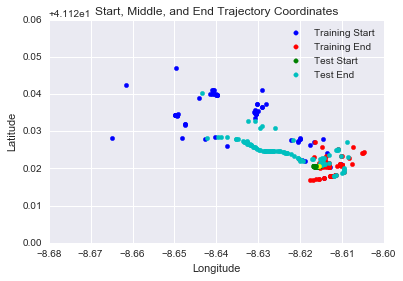

In [36]:
sortedCost = sorted(range(len(costArray)),key=lambda x:costArray[x])

# 100 closest
idx = sortedCost[:100]
c1 = plt.scatter(x = data7.startGPSLong[idx], y = data7.startGPSLat[idx], color = 'blue')
c2 = plt.scatter(x = data7.endGPSLong[idx], y = data7.endGPSLat[idx], color = 'red')
c3 = plt.scatter(x = data7.cutOffGPSLong[idx], y = data7.cutOffGPSLat[idx], color = 'green')
c4 = plt.scatter(x = data7.midGPSLong[idx], y = data7.midGPSLat[idx], color = 'c')

# test trajectory start and end
plt.scatter(x = testGPS[0][0], y = testGPS[0][1], color = 'yellow')
plt.scatter(x = testGPS[-1][0], y = testGPS[-1][1], color = 'green')

plt.legend((c1,c2,c3,c4),('Training Start','Training End','Test Start','Test End','Midpoint'))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Start, Middle, and End Trajectory Coordinates')

Below are tables that include the summary statistics for the following new features that were created above:

Variable | Description
--- | ---
velCO | velocity at the (training trajectory) point nearest (denoted the convergence point) the end of the partial test trajectory
sumDistVec_CE | distance traveled between the convergence point and the end of the trajectory
sumDistVec_EE | distance between the end of the training set trajectory and the end of the partial test trajectory
sunDistVec_SC | distance between the start of the training trjectory and the convergence cpoint of that trajectory
timeCE | time traveled between the convergence point and the end of the training set trajectory
timeSC | time it took to travel between the starting and convergence points of the training data

In [37]:
data7.loc[idx,['totalDist','velCO','sumDistVec_CE','sumDistVec_EE','sumDistVec_SC']].describe()

,totalDist,velCO,sumDistVec_CE,sumDistVec_EE,sumDistVec_SC
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.120840,4.674417,0.248513,0.252260,1.233633
std,0.939736,3.168754,0.115975,0.121024,0.783032
min,0.423555,0.000000,0.023050,0.023621,0.000000
25%,1.154804,2.207737,0.159939,0.157852,0.471977
50%,2.297392,4.479353,0.254830,0.255658,1.314239
75%,2.865216,6.768020,0.316812,0.319314,1.937318
max,4.254585,12.280703,0.622201,0.657412,2.799266


In [38]:
data7.loc[idx,['tripTime','timeCE','timeSC','velCO']].describe()

,tripTime,timeCE,timeSC,velCO
count,100.000000,100.000000,100.000000,100.000000
mean,9.720000,2.720000,6.390000,4.674417
std,3.417365,1.688224,3.868795,3.168754
min,5.000000,0.000000,0.000000,0.000000
25%,7.000000,1.000000,4.000000,2.207737
50%,9.500000,2.000000,7.000000,4.479353
75%,12.000000,4.000000,9.000000,6.768020
max,19.000000,7.000000,16.000000,12.280703


### Part III: Identifying Clusters in DTW

The plot of the starting, end, and midpoints suggests the trips either cover long distances or are restricted to the region covered by the cluster of end points (red). To see if the trips can be further clustered, I examined the relationship between the above features, bearing, and position.

A description of the additional features created are below:

Variable | Description
--- | ---
SCo2_bear | bearing between the starting point and the point nearest the end point of the partial test trajectory
CCo2_bear, _ang | bearing or angle between the center of Porto, Portugal and the point nearest the end of the partial test trajectory
cutOffGPSLong, cutOffGPSLat | the longitude and latitude of the point nearest the end of the partial test trajectory

Some important relationships with abs(correlation values) >= 0.5 are plotted below. Distance related variables that are highly correlated to time are not plotted since I established a relationship between time and distance earlier.  The red dot denotes the test set.

**Abbreviations:**

Abbr | Description
--- | ---
S-C | relationship between the starting point and the point nearest the end point of the partial test trajectory (convergence point)
C-C | is an abbreviation for the relationship between the city center and the convergence point

In [39]:
correlations = data7.loc[idx,['sumDistVec_CE','sumDistVec_EE','sumDistVec_SC','timeCE',\
               'timeSC','velCO','SCo2_bear','cutOffGPSLong','cutOffGPSLat',\
               'CCo2_bear','CCo2_ang','absDist']].corr()
correlations

,sumDistVec_CE,sumDistVec_EE,sumDistVec_SC,timeCE,timeSC,velCO,SCo2_bear,cutOffGPSLong,cutOffGPSLat,CCo2_bear,CCo2_ang,absDist
sumDistVec_CE,1.000000,0.980247,-0.344382,0.331598,-0.315079,-0.189540,-0.375128,0.150196,0.055959,-0.135239,0.145852,-0.344382
sumDistVec_EE,0.980247,1.000000,-0.421097,0.357382,-0.352532,-0.270446,-0.452193,0.284905,0.173061,-0.270531,0.280844,-0.421097
sumDistVec_SC,-0.344382,-0.421097,1.000000,-0.594603,0.738992,0.440379,0.719408,-0.649098,-0.579323,0.652702,-0.651405,1.000000
timeCE,0.331598,0.357382,-0.594603,1.000000,-0.501200,-0.469629,-0.576726,0.402650,0.236454,-0.380097,0.396403,-0.594603
timeSC,-0.315079,-0.352532,0.738992,-0.501200,1.000000,0.279826,0.609149,-0.474527,-0.426994,0.476747,-0.476430,0.738992
velCO,-0.189540,-0.270446,0.440379,-0.469629,0.279826,1.000000,0.553540,-0.471307,-0.189199,0.430120,-0.458524,0.440379
SCo2_bear,-0.375128,-0.452193,0.719408,-0.576726,0.609149,0.553540,1.000000,-0.547914,-0.424474,0.538492,-0.545829,0.719408
cutOffGPSLong,0.150196,0.284905,-0.649098,0.402650,-0.474527,-0.471307,-0.547914,1.000000,0.825700,-0.993986,0.999379,-0.649098
cutOffGPSLat,0.055959,0.173061,-0.579323,0.236454,-0.426994,-0.189199,-0.424474,0.825700,1.000000,-0.882440,0.845065,-0.579323
CCo2_bear,-0.135239,-0.270531,0.652702,-0.380097,0.476747,0.430120,0.538492,-0.993986,-0.882440,1.000000,-0.997223,0.652702


Axes(0.125,0.125;0.62x0.775)


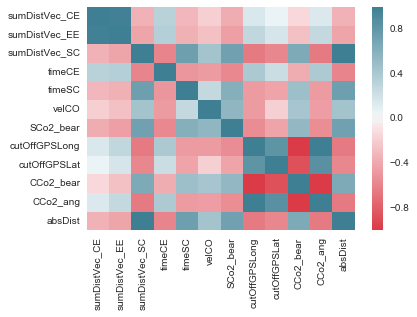

In [40]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
print sns.heatmap(correlations, cmap=cmap)

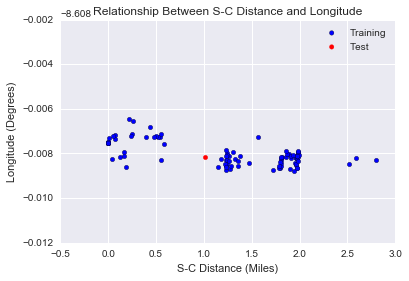

In [41]:
c1 = plt.scatter(x = data7.loc[idx,['sumDistVec_SC']], y = data7.loc[idx,['cutOffGPSLong']]) #neg corr
plt.ylim(-8.62,-8.61)
c2 = plt.scatter(x = testTrip['totalDist'], y = testGPS[-1][0], color = 'r')

plt.xlabel('S-C Distance (Miles)')
plt.ylabel('Longitude (Degrees)')
plt.title('Relationship Between S-C Distance and Longitude')
plt.legend((c1,c2),('Training','Test'))

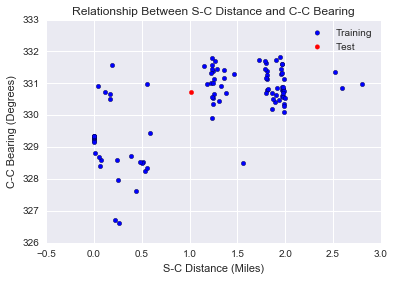

In [42]:
c1 = plt.scatter(x = data7.loc[idx,['sumDistVec_SC']], y = data7.loc[idx,['CCo2_bear']])
c2 = plt.scatter(x = testTrip['totalDist'], y = testTrip.CE_bear, color = 'r')
plt.legend((c1,c2),('Training','Test'))
plt.title('Relationship Between S-C Distance and C-C Bearing')
plt.xlabel('S-C Distance (Miles)')
plt.ylabel('C-C Bearing (Degrees)')

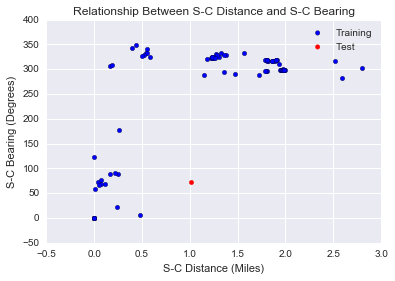

In [43]:
c1 = plt.scatter(x = data7.loc[idx,['sumDistVec_SC']], y = data7.loc[idx,['SCo2_bear']])
c2 = plt.scatter(x = testTrip['totalDist'], y = testTrip.SE_bear, color = 'r')
plt.legend((c1,c2),('Training','Test'))
plt.xlabel('S-C Distance (Miles)')
plt.ylabel('S-C Bearing (Degrees)')
plt.title('Relationship Between S-C Distance and S-C Bearing')

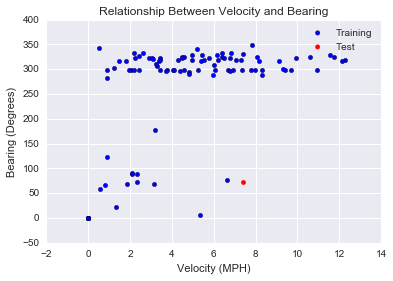

In [44]:
c1 = plt.scatter(x = data7.loc[idx,['velCO']], y = data7.loc[idx,['SCo2_bear']])
c2 = plt.scatter(x = testTrip.vel_endPt, y = testTrip.SE_bear, color = 'r')
plt.xlabel('Velocity (MPH)')
plt.ylabel('Bearing (Degrees)')
plt.title('Relationship Between Velocity and Bearing')
plt.legend((c1,c2),('Training','Test'))

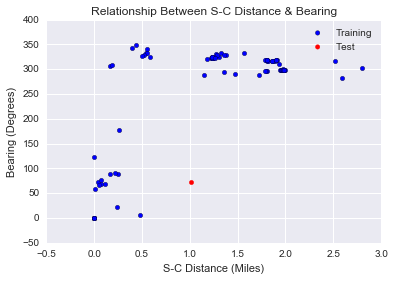

In [45]:
c1 = plt.scatter(x = data7.loc[idx,['sumDistVec_SC']], y = data7.loc[idx,['SCo2_bear']])
c2 = plt.scatter(x = testTrip.totalDist, y = testTrip.SE_bear, color = 'r')
plt.xlabel('S-C Distance (Miles)')
plt.ylabel('Bearing (Degrees)')
plt.title('Relationship Between S-C Distance & Bearing')
plt.legend((c1,c2),('Training','Test'))

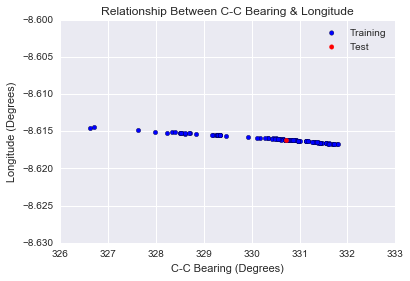

In [46]:
c1 = plt.scatter(x = data7.loc[idx,['CCo2_bear']], y = data7.loc[idx,['cutOffGPSLong']]) #neg corr
c2 = plt.scatter(x = testTrip['CE_bear'], y = testGPS[-1][0], color = 'r')
plt.legend((c1,c2),('Training','Test'))
plt.xlabel('C-C Bearing (Degrees)')
plt.ylabel('Longitude (Degrees)')
plt.title('Relationship Between C-C Bearing & Longitude')

### Part IV: kMeans Clustering

The relationship between the S-C bearing and the longitude of the point nearest the end of the partial trajectory displays 3 well defined clusters that are inclusive of the test data. I used kmeans (k=3) to systematically assign the test data to a cluster. The red x denotes the test data.

[-0.5, 3.0, -8.62, -8.61]

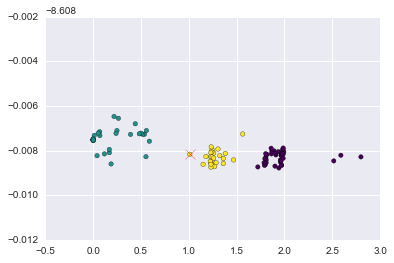

In [47]:
df_dist_long = data7.loc[idx,['sumDistVec_SC','cutOffGPSLong']].reset_index(drop = True)
df_dist_long.loc[len(df_dist_long),['sumDistVec_SC','cutOffGPSLong']] = list([testTrip['totalDist'], testGPS[-1][0]])

km = cluster.KMeans(n_clusters=3)
km.fit(df_dist_long)
df_dist_long['pred_group'] = km.labels_

plt.scatter(df_dist_long['sumDistVec_SC'], df_dist_long['cutOffGPSLong'], c=df_dist_long['pred_group'],\
            cmap=plt.get_cmap('viridis'))
plt.scatter(x = testTrip['totalDist'], y = testGPS[-1][0], color = 'r', s=100, marker='x')
plt.axis([-0.5, 3.0, -8.62,-8.61])

#df_dist_long.tail()

Below, the starting points are plotted and are colored by cluster. The gray dots are the end points of each cluster. The star is the start point of the partial test trajectory and is colored the same as its cluster.

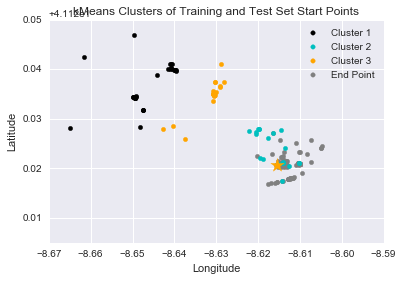

In [48]:
#plot start and end GPS with cluster labels
c0 = plt.scatter(x = data7.endGPSLong[idx], y = data7.endGPSLat[idx], color = 'gray')

colors = ['k','c','orange']

idx2 = list(np.where(df_dist_long.loc[0:len(df_dist_long)-2,'pred_group'] == 0)[0])
idx2 = [idx[i] for i in idx2]
c1 = plt.scatter(x = data7.startGPSLong[idx2], y = data7.startGPSLat[idx2], color = colors[0])

idx2 = list(np.where(df_dist_long.loc[0:len(df_dist_long)-2,'pred_group'] == 1)[0])
idx2 = [idx[i] for i in idx2]
c2 = plt.scatter(x = data7.startGPSLong[idx2], y = data7.startGPSLat[idx2], color = colors[1])

idx2 = list(np.where(df_dist_long.loc[0:len(df_dist_long)-2,'pred_group'] == 2)[0])
idx2 = [idx[i] for i in idx2]
c3 = plt.scatter(x = data7.startGPSLong[idx2], y = data7.startGPSLat[idx2], color = colors[2])

plt.scatter(x = testGPS[0][0], y = testGPS[0][1],\
            color = colors[int(df_dist_long.loc[len(df_dist_long)-1,'pred_group'])],s = 200,marker = '*')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend((c1,c2,c3,c0),('Cluster 1','Cluster 2','Cluster 3','End Point'))
plt.title('kMeans Clusters of Training and Test Set Start Points')

Below, the end points are plotted and are colored by cluster. The gray dots are the start points of each cluster. The star is the end point of the partial test trajectory and is colored the same as its cluster.

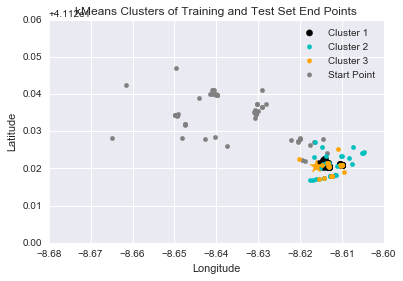

In [49]:
#plot start and end GPS with cluster labels
c0 = plt.scatter(x = data7.startGPSLong[idx], y = data7.startGPSLat[idx], color = 'gray')

colors = ['k','c','orange']

idx2 = list(np.where(df_dist_long.loc[0:len(df_dist_long)-2,'pred_group'] == 0)[0])
idx2 = [idx[i] for i in idx2]
c1 = plt.scatter(x = data7.endGPSLong[idx2], y = data7.endGPSLat[idx2], color = colors[0],s=40)

idx2 = list(np.where(df_dist_long.loc[0:len(df_dist_long)-2,'pred_group'] == 1)[0])
idx2 = [idx[i] for i in idx2]
c2 = plt.scatter(x = data7.endGPSLong[idx2], y = data7.endGPSLat[idx2], color = colors[1])

idx2 = list(np.where(df_dist_long.loc[0:len(df_dist_long)-2,'pred_group'] == 2)[0])
idx2 = [idx[i] for i in idx2]
c3 = plt.scatter(x = data7.endGPSLong[idx2], y = data7.endGPSLat[idx2], color = colors[2])

plt.scatter(x = testGPS[-1][0], y = testGPS[-1][1],\
            color = colors[int(df_dist_long.loc[len(df_dist_long)-1,'pred_group'])],s = 200,marker = '*')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend((c1,c2,c3,c0),('Cluster 1','Cluster 2','Cluster 3','Start Point'))
plt.title('kMeans Clusters of Training and Test Set End Points')

kMeans clustering reveals an interesting pattern- the trips that begin the farthest from the point of convergence tend to converge on to one spot. This spot covers a large palace (and popular tourist destination) located along a river in Porto, Portugal. The trips that clustered within the blue and black clusters and originated closer to the convergence point tended to overlap. These spots are near popular museums, cathedrals, and squares.

## Regression Analysis: Decision Trees

To predict the trip time and distance of the partial test trip, I regressed the DTW and the DTW + kmeans clusters using Decision Tree Regression.

A summary of the results is below:

Cluster | Algorithm | Time Prediction (Minutes), MSE | Distance Prediction (Miles), MSE
--- | --- | --- | ---
DTW | Decision Tree | 5, 0.12 | 2.26, 0.30
DTW + kMeans | Decision Tree | 6, 1.625 | 0.60, 1.01

The MSE is smallest for the DTW cluster. The test trip is likely to be around 5 minutes and 2.3 miles long.

### Part I: Predicting Trip Time

First, the names of the columns in the test trip data frame were changed to match the column names in the training set.

In [50]:
# change names of test df to match train df
test_columns = ['CE_ang', 'CE_bear','SE_ang', 'SE_bear',\
                'endGPSLat', 'endGPSLong', 'startGPSLat', 'startGPSLong',\
                'lenGPS','totalDist', 'tripTime', 'vel_endPt']
test_df = testTrip.loc[test_columns]
test_columns[-1] = 'velCO'
test_columns[4] = 'cutOffGPSLat'
test_columns[5] = 'cutOffGPSLong'
test_columns[10] = 'timeSC'
test_columns[9] = 'sumDistVec_SC'
test_columns[2] = 'SCo_ang'
test_columns[3] = 'SCo_bear'
test_columns[0] = 'CCo2_ang'
test_columns[1] = 'CCo2_bear'
test_df['SCo2_bear'] = computeBearing(testGPS[0],testGPS[-1])

test_df.index = test_columns + list(['SCo2_bear'])

Decision tree regression: DTW cluster, top 100 similar training trajectories

Best score: 0.12
Max depth:{'max_depth': 13}


C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Predition, T40 (min): [ 5.]


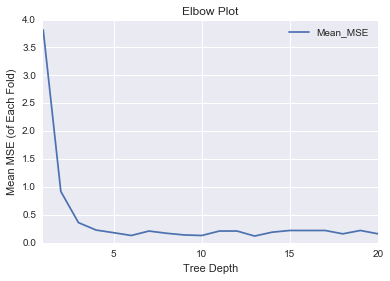

In [51]:
colNames = ['SCo_ang', 'SCo_bear', 'cutOffGPSLat', 'cutOffGPSLong',\
            'startGPSLat', 'startGPSLong', 'lenGPS', 'sumDistVec_SC', 'timeSC', 'velCO', 'SCo2_bear','tripTime',\
            'CCo2_bear','CCo2_ang']
df2 = data7.loc[idx,:].reset_index(drop = True)
x = df2[colNames]
y = x.tripTime
x = x.drop('tripTime',axis=1)

max_depths = np.arange(1,21)

gs1 = grid_search.GridSearchCV(
    estimator=tree.DecisionTreeRegressor(),
    param_grid={'max_depth': max_depths},
    scoring = 'mean_squared_error',
    cv=5
)
gs1.fit(x,y)

print 'Best score: ' + str(-gs1.best_score_)
print 'Max depth:' + str(gs1.best_params_)
#print gs1.best_estimator_
print 'Predition, T40 (min): ' + str(gs1.predict(test_df[list(x.columns)]))

mean_score = [-g[1] for g in gs1.grid_scores_]
sdev_score = [np.std(g[2]) for g in gs1.grid_scores_]


grid_res = pd.DataFrame(list(zip(max_depths, mean_score, sdev_score)), \
                        columns=['Depth', 'Mean_MSE', 'Sdev_MSE'])

grid_res.plot('Depth','Mean_MSE')

plt.xlabel('Tree Depth')
plt.ylabel('Mean MSE (of Each Fold)')
plt.title('Elbow Plot')

Decision tree regression: kMeans cluster (following DTW)

Best score: 1.625
Max depth:{'max_depth': 14}


C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Predition, T40 (min): [ 6.]


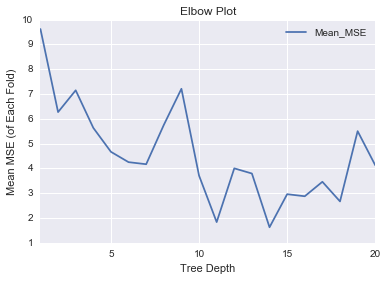

In [52]:
df_dist_long.loc[len(df_dist_long)-1,'pred_group']
idx2 = list(np.where(df_dist_long.loc[0:len(df_dist_long)-2,'pred_group'] == df_dist_long.loc[len(df_dist_long)-1,'pred_group'])[0])

df2 = data7.loc[idx2,:].reset_index(drop = True)
x = df2[colNames]
y = x.tripTime
x = x.drop('tripTime',axis=1)

max_depths = np.arange(1,21)

gs2 = grid_search.GridSearchCV(
    estimator=tree.DecisionTreeRegressor(),
    param_grid={'max_depth': max_depths},
    scoring = 'mean_squared_error',
    cv=5
)
gs2.fit(x,y)

print 'Best score: ' + str(-gs2.best_score_)
print 'Max depth:' + str(gs2.best_params_)
#print gs1.best_estimator_
print 'Predition, T40 (min): ' + str(gs2.predict(test_df[list(x.columns)]))

mean_score = [-g[1] for g in gs2.grid_scores_]
sdev_score = [np.std(g[2]) for g in gs2.grid_scores_]


grid_res = pd.DataFrame(list(zip(max_depths, mean_score, sdev_score)), \
                        columns=['Depth', 'Mean_MSE', 'Sdev_MSE'])

grid_res.plot('Depth','Mean_MSE')

plt.xlabel('Tree Depth')
plt.ylabel('Mean MSE (of Each Fold)')
plt.title('Elbow Plot')

### Part II: Predicting Trip Distance

Decision Tree: DTW

Best score: 0.29980637854
Max depth:{'max_depth': 2}


C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Predition, T40 (Miles): [ 2.25796877]


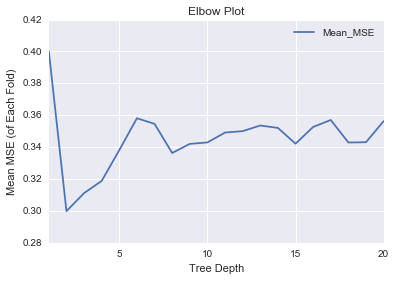

In [56]:
colNames = ['SCo_ang', 'SCo_bear', 'cutOffGPSLat', 'cutOffGPSLong',\
            'startGPSLat', 'startGPSLong', 'lenGPS', 'sumDistVec_SC', 'timeSC', 'velCO', 'SCo2_bear',\
            'CCo2_bear','CCo2_ang','totalDist']
df2 = data7.loc[idx,:].reset_index(drop = True)
x = df2[colNames]
y = x.totalDist
x = x.drop('totalDist',axis=1)

max_depths = np.arange(1,21)

gs3 = grid_search.GridSearchCV(
    estimator=tree.DecisionTreeRegressor(),
    param_grid={'max_depth': max_depths},
    scoring = 'mean_squared_error',
    cv=5
)
gs3.fit(x,y)

print 'Best score: ' + str(-gs3.best_score_)
print 'Max depth:' + str(gs3.best_params_)
#print gs1.best_estimator_
print 'Predition, T40 (Miles): ' + str(gs3.predict(test_df[list(x.columns)]))

mean_score = [-g[1] for g in gs3.grid_scores_]
sdev_score = [np.std(g[2]) for g in gs3.grid_scores_]


grid_res = pd.DataFrame(list(zip(max_depths, mean_score, sdev_score)), \
                        columns=['Depth', 'Mean_MSE', 'Sdev_MSE'])

grid_res.plot('Depth','Mean_MSE')

plt.xlabel('Tree Depth')
plt.ylabel('Mean MSE (of Each Fold)')
plt.title('Elbow Plot')

Decision Tree: kMeans (Following DTW)

Best score: 1.10414958008
Max depth:{'max_depth': 15}


C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Predition, T40 (Miles): [ 0.59758897]


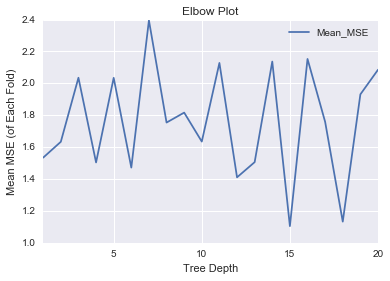

In [55]:
colNames = ['SCo_ang', 'SCo_bear', 'cutOffGPSLat', 'cutOffGPSLong',\
            'startGPSLat', 'startGPSLong', 'lenGPS', 'sumDistVec_SC', 'timeSC', 'velCO', 'SCo2_bear',\
            'CCo2_bear','CCo2_ang','totalDist']
df2 = data7.loc[idx2,:].reset_index(drop = True)
x = df2[colNames]
y = x.totalDist
x = x.drop('totalDist',axis=1)

max_depths = np.arange(1,21)

gs4 = grid_search.GridSearchCV(
    estimator=tree.DecisionTreeRegressor(),
    param_grid={'max_depth': max_depths},
    scoring = 'mean_squared_error',
    cv=5
)
gs4.fit(x,y)

print 'Best score: ' + str(-gs4.best_score_)
print 'Max depth:' + str(gs4.best_params_)
#print gs1.best_estimator_
print 'Predition, T40 (Miles): ' + str(gs4.predict(test_df[list(x.columns)]))

mean_score = [-g[1] for g in gs4.grid_scores_]
sdev_score = [np.std(g[2]) for g in gs4.grid_scores_]


grid_res = pd.DataFrame(list(zip(max_depths, mean_score, sdev_score)), \
                        columns=['Depth', 'Mean_MSE', 'Sdev_MSE'])

grid_res.plot('Depth','Mean_MSE')

plt.xlabel('Tree Depth')
plt.ylabel('Mean MSE (of Each Fold)')
plt.title('Elbow Plot')